In [ ]:
import numpy as np 
import pandas as pd
import os
import librosa
import wave
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import *
from keras.optimizer_v1 import rmsprop
from keras.models import Sequential

from pydub import AudioSegment, effects
import noisereduce as nr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sample_lengths = []

for dirname, _,filenames in os.walk('/content/drive/MyDrive/audio_speech_actors_01-24'):
  for filename in filenames:
    wav_file_name =os.path.join(dirname , filename)
    _, sr = librosa.load(path =wav_file_name, sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    rawsound = AudioSegment.from_file(wav_file_name) 
    normalizedsound = effects.normalize(rawsound, headroom = 0) 
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    xt, index = librosa.effects.trim(normal_x, top_db=30)
     
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths)) 

Maximum sample length: 228864


In [ ]:
total_length = 228864  
frame_length = 2048
hop_length = 512
#Load Dataset
zcr_data= []
rms_data= []
mfccs_data= []
radvess_speech_labels = []

for dirname, _,filenames in os.walk('/content/drive/MyDrive/audio_speech_actors_01-24'):
  for filename in filenames:
    wav_file_name =os.path.join(dirname , filename)
    radvess_speech_labels.append(int(filename[7:8])-1)
    _, sr = librosa.load(path =wav_file_name, sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    rawsound = AudioSegment.from_file(wav_file_name) 
    normalizedsound = effects.normalize(rawsound, headroom = 0) 
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')

    final_x = nr.reduce_noise(padded_x, sr=sr)
    rms = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
    zcr = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR 
    mfccs=librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) 
    
    
    rms_data.append(rms)
    zcr_data.append(zcr)
    mfccs_data.append(mfccs)

In [ ]:
gender_label=[]
for dirname, _,filenames in os.walk('/content/drive/MyDrive/audio_speech_actors_01-24'):
  for filename in filenames:
    if(int(filename[18:20])%2==0):
      gender_label.append(0)
    else:
      gender_label.append(1)


In [ ]:
f_rms = np.asarray(rms_data).astype('float32')
f_zcr = np.asarray(zcr_data).astype('float32')
f_mfccs = np.asarray(mfccs_data).astype('float32')

In [ ]:
f_mfccs.ndim

3

In [ ]:
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (1440, 448, 1)
RMS shape: (1440, 448, 1)
MFCCs shape: (1440, 448, 13)


In [ ]:
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

Y = np.asarray(radvess_speech_labels).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(1260, 448, 15)
(125, 448, 15)
(55, 448, 15)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [ ]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

checkpoint_path = '/content/drive/My Drive/model_lstm.hdf5'


mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,monitor='val_categorical_accuracy',mode='max')

rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1, patience=100)
                             
 
model.compile(loss='categorical_crossentropy',optimizer='RMSProp', metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, epochs=340, batch_size = batch_size, validation_data = (x_val, y_val_class))

model.load_weights(checkpoint_path)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 448, 64)           20480     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/340
34/55 [=================>............] - ETA: 10s - loss: 2.0871 - categorical_accuracy: 0.1279

KeyboardInterrupt: ignored

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/model8723_weights.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

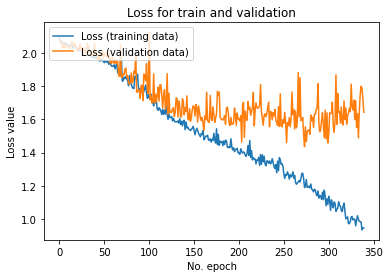

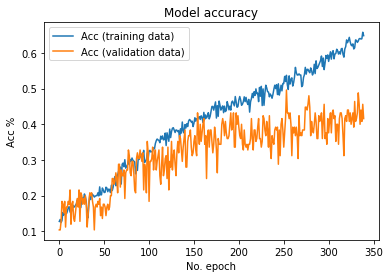

In [ ]:


# Plotting Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plotting Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

ValueError: ignored

In [ ]:
# Validation Confusion matrix

y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')


AxisError: ignored

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

In [ ]:
# Saving model & weights


from keras.models import load_model


saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

    
model.save_weights(saved_weights_path)
print("Saved model to disk")